In [16]:
import sys
import importlib
from types import SimpleNamespace
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.special import softmax
from joblib import Parallel, delayed
import seaborn as sns
import scipy as sp

import warnings
warnings.filterwarnings("ignore")

sys.path.append("../src")
sys.path.append("../configs")

sys.argv = ['--config', 'config1']

from models import *
from loss import *
from train import *
from data import *

In [2]:
def cos_similarity_matrix(a, b, eps=1e-8):
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt
def get_topk_cossim(test_emb, tr_emb, batchsize = 64, k=10, device='cuda:0',verbose=True):
    tr_emb = torch.tensor(tr_emb, dtype = torch.float32, device=torch.device(device))
    test_emb = torch.tensor(test_emb, dtype = torch.float32, device=torch.device(device))
    vals = []
    inds = []
    for test_batch in tqdm(test_emb.split(batchsize),disable=1-verbose):
        sim_mat = cos_similarity_matrix(test_batch, tr_emb)
        vals_batch, inds_batch = torch.topk(sim_mat, k=k, dim=1)
        vals += [vals_batch.detach().cpu()]
        inds += [inds_batch.detach().cpu()]
    vals = torch.cat(vals)
    inds = torch.cat(inds)
    return vals, inds
def get_topk_cossim_sub(test_emb, tr_emb, vals_x, batchsize = 64, k=10, device='cuda:0',verbose=True):
    tr_emb = torch.tensor(tr_emb, dtype = torch.float32, device=torch.device(device))
    test_emb = torch.tensor(test_emb, dtype = torch.float32, device=torch.device(device))
    vals_x = torch.tensor(vals_x, dtype = torch.float32, device=torch.device(device))
    vals = []
    inds = []
    for test_batch in tqdm(test_emb.split(batchsize),disable=1-verbose):
        sim_mat = cos_similarity_matrix(test_batch, tr_emb)
        sim_mat = torch.clamp(sim_mat,0,1) - vals_x.repeat(sim_mat.shape[0], 1)
        
        vals_batch, inds_batch = torch.topk(sim_mat, k=k, dim=1)
        vals += [vals_batch.detach().cpu()]
        inds += [inds_batch.detach().cpu()]
    vals = torch.cat(vals)
    inds = torch.cat(inds)
    return vals, inds

In [3]:
# pick your models
models = ["config1", "config2", "config3", "config4", "config5"]

In [4]:
from sklearn.preprocessing import normalize

tr_embeddings = []
val_embeddings = []
nonlandmark_embeddings = []
targets = []
targets_train = []
for m in models:
    with open(f"/home/psinger/projects/kaggle_landmark/blend/{m}/out_val.p", 'rb') as f:
        out_val = pickle.load(f)
    with open(f"/home/psinger/projects/kaggle_landmark/blend/{m}/out_tr_filter.p", 'rb') as f:
        out_tr_filter = pickle.load(f)

    uniques = np.unique(out_val["idx"], return_index=True)[1]
    for k,v in out_val.items():
        if k in ["embeddings", "targets", "idx"]:
            out_val[k] = v[uniques]
            
    uniques = np.unique(out_tr_filter["idx"], return_index=True)[1]
    for k,v in out_tr_filter.items():
        if k in ["embeddings", "targets", "idx"]:
            out_tr_filter[k] = v[uniques]

    tr_embeddings_x = out_tr_filter["embeddings"][np.argsort(out_tr_filter["idx"])]
    targets_train_x = out_tr_filter["targets"][np.argsort(out_tr_filter["idx"])]
    
    val_embeddings_x = out_val["embeddings"][np.argsort(out_val["idx"])]
    targets_x = out_val["targets"][np.argsort(out_val["idx"])]
    
    tr_embeddings_x = normalize(tr_embeddings_x, norm="l2")
    val_embeddings_x = normalize(val_embeddings_x, norm="l2")

    nonlandmark_embeddings_x = val_embeddings_x[targets_x==81313]
    
    tr_embeddings.append(tr_embeddings_x)
    val_embeddings.append(val_embeddings_x)
    nonlandmark_embeddings.append(nonlandmark_embeddings_x)
    targets.append(targets_x)
    targets_train.append(targets_train_x)

In [5]:
len(out_tr_filter["targets"])

60677

In [6]:
tr_embeddings = np.hstack(tr_embeddings)
val_embeddings = np.hstack(val_embeddings)
nonlandmark_embeddings = np.hstack(nonlandmark_embeddings)
targets = targets[0]
targets_train = targets_train[0]

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.random_projection import GaussianRandomProjection

f = QuantileTransformer(output_distribution="normal")

f.fit(np.concatenate([val_embeddings],axis=0))

tr_embeddings = f.transform(tr_embeddings)
val_embeddings = f.transform(val_embeddings)
nonlandmark_embeddings = f.transform(nonlandmark_embeddings)

In [11]:
# calculate A-B

EMB_SIZE = 512
vals_blend = []

labels_blend = []
inds_blend = []
for i in range(len(models)):
    
    vals_nl, inds_nl = get_topk_cossim(tr_embeddings[:,i*EMB_SIZE:(i+1)*EMB_SIZE], nonlandmark_embeddings[:,i*EMB_SIZE:(i+1)*EMB_SIZE], k=5)
    vals_nl = vals_nl[:,:].mean(axis=1).detach().cpu().numpy()
    
    vals, inds = get_topk_cossim_sub(val_embeddings[:,i*EMB_SIZE:(i+1)*EMB_SIZE], tr_embeddings[:,i*EMB_SIZE:(i+1)*EMB_SIZE], vals_nl, k=3)
    vals = vals.data.cpu().numpy()
    inds = inds.data.cpu().numpy()
    labels = np.concatenate([targets_train[inds[:,i]].reshape(-1,1) for i in range(inds.shape[1])], axis=1)
    
    vals_blend.append(vals)
    labels_blend.append(labels)
    inds_blend.append(inds)

In [12]:
vals = np.concatenate(vals_blend, axis=1)
inds = np.concatenate(inds_blend, axis=1)
labels = np.concatenate(labels_blend, axis=1)

In [13]:
# pick most similar images based on sum
from collections import defaultdict

vals_new = []
labels_new = []

for i in tqdm(range(len(vals))):
    cnts = defaultdict(list)

    x = 0
    for j,l in enumerate(labels[i,:]):

        curr = vals[i][j]

        cnts[l].append(curr)

    for k,v in cnts.items():
        cnts[k] = np.sum(v)
        
    labels_new.append(max(cnts, key=cnts.get))
    vals_new.append(cnts[labels_new[-1]])
        
l = np.array(labels_new).reshape(-1)
v = np.array(vals_new).reshape(-1)

val_score = comp_metric(targets, [l, v], ignore_non_landmarks=False)
print(val_score)
val_score = comp_metric(targets, [l, v], ignore_non_landmarks=True)
print(val_score)


0.8832146897975875
0.9023401032988307


<AxesSubplot:ylabel='Density'>

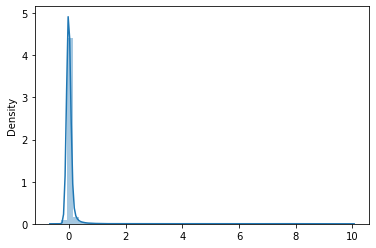

In [21]:
sns.distplot(v)

In [22]:
vals_2, inds_2 = get_topk_cossim(val_embeddings, nonlandmark_embeddings, k=11)
# starting from index 1 on val as index 0 is the same image
vals_2 = vals_2[:,1:].mean(axis=1).detach().cpu().numpy()

In [24]:
# penalize by C
import scipy as sp

l3 = pd.Series(l.copy()).reset_index(drop=True)
v3 = v.copy()

v3 -= 1*vals_2

val_score = comp_metric(out_val["targets"][:], [l3[:], v3[:]], ignore_non_landmarks=False)
print(val_score)
val_score = comp_metric(out_val["targets"][:], [l3[:], v3[:]], ignore_non_landmarks=True)
print(val_score)

0.8838247544286192
0.9023626089331723


<AxesSubplot:ylabel='Density'>

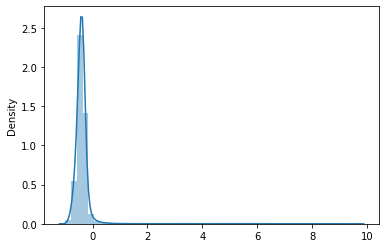

In [27]:
sns.distplot(v3)